In [1]:
from __future__ import division
import os, sys, time, random
import math
import scipy
from scipy import constants
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd import grad
import autograd.numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from scipy.constants import pi


In [2]:
class Potential(nn.Module):
    def __init__(self):
        super(Potential,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,128),
            nn.Tanh()
        )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(32,128),
#             nn.Tanh()
#         )
        self.hidden1 = nn.Sequential(
            nn.Linear(128,128),
           nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = x + self.hidden1(x)
       # x = x + self.hidden2(x)
        x = 10*self.out(x)
        return x

In [3]:
#Sigmoid in the output layer is causing issues
class New_Dist(nn.Module): 
    def __init__(self):
        super(New_Dist,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,128),
            nn.Tanh()
        )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(32,128),
#             nn.Tanh()
#         )
        self.hidden1 = nn.Sequential(
            nn.Linear(128,128),
            nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(128,1)
          )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = x + self.hidden1(x)
       # x = x + self.hidden2(x)
        x = self.out(x)
        return x

In [4]:
hbar = 1
m = 1
# Define parameters of the system
L = 1.0
norm1 = 1.0074

def psi0(n,x,L):  
    A = np.sqrt(2./L)
    kn = n*pi/L
    #psi = A*torch.sin(kn*x)
    psi = A*torch.sin(kn*x) 
    return psi

def E0(n,L):  
    kn = n*pi/L
    E = (hbar*kn)**2/(2*m)
    return E

def vpert2(V0,x,L):
    V = V0*((x/L)**2)
    return V


#V0=10
def coeff(n,k,L):
    x = np.arange(0,L,.001)
    x = torch.from_numpy(x)
    ck = torch.trapz(psi0(n,x,L)*vpert2(10,x,L)*psi0(k,x,L),x)/(E0(n,L)-E0(k,L))
    return ck

def psi_perturbed_torch(n,x,L,kmax):
    psi_wperturbation = psi0(n,x,L) # Start off with the zeroth order wavefunction, with coefficient = 1
    #print('psi0',psi_wperturbation)
    ik = 0
    for k in range(1,kmax):
        if k==n:
            pass
        else:
            ck = coeff(n,k,L)
            #ck =torch.trapz(psi0(n,x,L)*V*psi0(k,x,L),x)/(E0(n,L)-E0(k,L)) # Calculate the coefficient for the kth 0-order eigenfunction
            #Integral without x sampling points
           # ck =torch.trapz(psi0(n,x,L)*V*psi0(k,x,L))/(E0(n,L)-E0(k,L)) # Calculate the coefficient for the kth 0-order eigenfunction
            #print(ik,'k',k,'ck',ck,ck**2)
            psi_wperturbation +=(ck*psi0(k,x,L)) # Add that contribution to the corrected eigenfunction, with appropriate coefficient
        ik += 1
# Normalize
   # norm1 = torch.trapz(psi_wperturbation*psi_wperturbation,x) # Get <psi|psi> for the corrected eigenfunction 
   # psi_wperturbation = psi_wperturbation/norm1**.5 # Normalize this |psi>
   # norm2 = torch.trapz(psi_wperturbation**2,x) # Just checking that the new <psi|psi> equals 1
   # print ("Old, new normalization:", norm1, norm2) 
    #print(psi_wperturbation) 
    return psi_wperturbation/norm1

In [5]:
n = 1
kmax = 100
V0 = 10

In [7]:
potential = Potential()
optimizer_p = torch.optim.Adam(potential.parameters(), lr = .001)
#potential.load_state_dict(torch.load('PIB_working_confident.pkl'))
#del_t = .001
new_prob_dist = New_Dist()
optimizer_d = torch.optim.Adam(new_prob_dist.parameters(), lr = .001)
#new_prob_dist.load_state_dict(torch.load('perturbed_wave_confident_working.pkl'))


In [8]:
def conserve_energy(batch):
   # output = new_prob_dist(batch)
    output = psi_perturbed_torch(1,batch,1, 100)
   # output = torch.sqrt(output)
    output.requires_grad_(True)
    potential_energy = potential(batch)
    potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                  only_inputs=True,
                   allow_unused=True
                )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                   create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    return grad((-np.sqrt(2)* pi * pi * torch.sin(pi*batch) + kinetic_energy)/(psi0(1,batch,1) + output)  - potential_energy, batch, grad_outputs = torch.ones_like(batch), 
                   create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                 )[0]


In [9]:
x_range = [0,1]
#Better to get from data
def sample_x(size):
    '''
    Uniform random x sampling within range
    '''
    x = (x_range[0] - x_range[1]) * torch.rand(size,1) + x_range[1]
    return x


In [10]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [12]:
data = sample_x(4000)
dataset = MyDataset(data)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [ ]:
num_epochs = 1500
loss = []
for epoch in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch, requires_grad=True)
     
        optimizer_p.zero_grad()
        optimizer_d.zero_grad()
        output = new_prob_dist(n_data)
      
        target = psi_perturbed_torch(1,n_data,1, 100)**2
        energy = conserve_energy(n_data)
        
        error = ((output - target)**2).mean() + (energy**2).mean()
       
      
        error.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(potential.parameters(), .9)
       
        optimizer_p.step()
        optimizer_d.step()
  


In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, title, show, xlabel, ylabel, legend


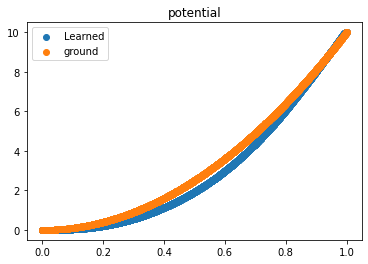

In [17]:
plt.scatter(data.detach().numpy(), potential.cpu()(data).detach().numpy())
plt.scatter(data.detach().numpy(), 10*pow(data,2).detach().numpy())
plt.title("potential")
plt.legend(['Learned', 'ground'])
plt.show()

In [25]:
x = torch.rand(50,1)
x.requires_grad_(True)
y = new_prob_dist(x)

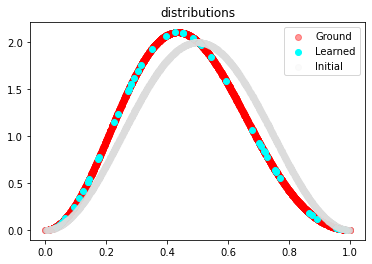

In [28]:
plt.scatter(data.detach().numpy(), pow(psi_perturbed_torch(1,data,1, 100),2).detach().numpy(), color = 'red', alpha=.4)
#plt.scatter(data.detach().numpy(), y.detach().numpy()*y.detach().numpy())
plt.scatter(x.detach().numpy(), y.detach().numpy(), color = 'aqua')
plt.scatter(data.detach().numpy(), pow(psi0(1,data,1).detach().numpy(),2), color = 'gainsboro', alpha= .1)
plt.title("distributions")
plt.legend(['Ground','Learned', 'Initial'])
plt.show()

Rest of the notebook is dedicated to get the figures in the main text and can be ignored.

In [13]:
x_coord = sample_x(4000)


In [14]:
x_coord.detach().numpy()

array([[0.39744735],
       [0.6282222 ],
       [0.64230704],
       ...,
       [0.5768469 ],
       [0.13583994],
       [0.06009287]], dtype=float32)

In [15]:
import pandas as pd

In [16]:
learned_wave = new_prob_dist(x_coord).detach().numpy()
learned_wave[3000],x_coord.detach().numpy()[3000]

(array([0.23233134], dtype=float32), array([0.92628896], dtype=float32))

In [17]:
output=[]
for i in range(0,len(learned_wave)):
    output.append((x_coord.detach().numpy()[i][0],learned_wave[i][0]))

In [18]:
sorted_output = sorted(output, key=lambda x: x[0])

In [19]:
xsorted = []
wavesorted=[]
for i in sorted_output:
    xsorted.append(i[0])
    wavesorted.append(i[1])

In [20]:
dictlearned={'x':xsorted,'wave_learned':wavesorted}

In [114]:
initial = psi0(1,x_coord,1).detach().numpy()
output_initial=[]
for i in range(0,len(initial)):
    output_initial.append((x_coord.detach().numpy()[i][0],initial[i][0]))
sorted_initial = sorted(output_initial, key=lambda x: x[0])

In [115]:
perturbed = psi_perturbed_torch(1,x_coord,1, 100).detach().numpy()
output_perturbed=[]
for i in range(0,len(perturbed)):
    output_perturbed.append((x_coord.detach().numpy()[i][0],perturbed[i][0]))
sorted_perturbed = sorted(output_perturbed, key=lambda x: x[0])

In [116]:
#dictplot= {'x':xsorted,'Learned Potential':potsorted, 'Ground Potential':potgroundsorted}

In [117]:
x_initial=[]
y_initial=[]
for a in sorted_initial:
    x_initial.append(a[0])
    y_initial.append(a[1])

In [118]:
x_perturb=[]
y_perturb=[]
for a in sorted_perturbed:
    x_perturb.append(a[0])
    y_perturb.append(a[1])

In [119]:
len(output_initial[0])

2

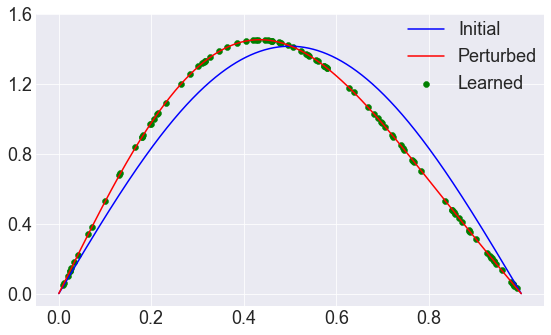

In [124]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
x = sample_x(100)
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot()
# ax.set_title('Ground and Learned Potentials')
#ax.set_xlabel('Position')
#ax.set_ylabel('Potential')
plt.plot(x_initial,y_initial,color='b',linewidth=1.5)
plt.plot(x_perturb,y_perturb, color='r', linewidth=1.5)
plt.scatter(x, new_prob_dist.cpu()(x).detach().numpy(),color='g',linestyle='-',marker='o',linewidth=0.5)
#plt.plot(xsorted,potsorted,color='g',linewidth='1',alpha=0.5)
# Create an inset outside the axes
# plt.suptitle("Ground and Learned Potentials", fontsize=13, fontweight=0, color='black', style='italic')

#plt.legend(['Initial','Perturbed','Learned'],bbox_to_anchor=(0.1, 0.93), loc='upper right', borderaxespad=0.0)
plt.legend(['Initial','Perturbed','Learned'], loc='upper right', borderaxespad=0.0)
# Create an inset with a 2-tuple bounding box. Note that this creates a
# bbox without extent. This hence only makes sense when specifying
# width and height in absolute units (inches).
# axins2 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.05, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)

# axins2.plot(xgroundsorted,potgroundsorted,label='Ground',color='b')
# axins2.set_xlabel('Position')
# axins2.set_ylabel('Potential')
# axins2.set_title('Ground Potential')

# axins3 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.39, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)
# axins3.plot(xgroundsorted,potsorted,label='Learned',color='g')
# axins3.set_xlabel('Position')
# axins3.set_ylabel('Potential')
# axins3.set_title('Learned Potential')

major_ticks_x = np.arange(0, 1, .2)
minor_ticks_x = np.arange(0, 1, .2)
major_ticks_y = np.arange(0, 2, .4)
minor_ticks_y = np.arange(0, 2, .4)
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
plt.rc('font', size=18)
plt.rc('axes', titlesize=18) 

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
plt.tight_layout()
plt.savefig('PIB_wave_functions',dpi=1200)

In [64]:
def learned_energy_function(batch):
    batch.requires_grad_(True)
    output = psi_perturbed_torch(1,batch,1, 100)
   # output = torch.sqrt(output)
    output.requires_grad_(True)
    potential_energy = potential(batch)
    potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                  only_inputs=True,
                   allow_unused=True
                )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                   create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    return (-np.sqrt(2)* pi * pi * torch.sin(pi*batch) + kinetic_energy)/(psi0(1,batch,1) + output)  - potential_energy




In [65]:
def ground_energy(batch):
    batch.requires_grad_(True)
    output = psi_perturbed_torch(1,batch,1, 100)
   # output = torch.sqrt(output)
    output.requires_grad_(True)
    potential_energy = 10*(batch)**2
    potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                  only_inputs=True,
                   allow_unused=True
                )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                   create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    return (-np.sqrt(2)* pi * pi * torch.sin(pi*batch) + kinetic_energy)/(psi0(1,batch,1) + output) - potential_energy

In [66]:
x_coord = sample_x(4000)
learned_energy1 = -learned_energy_function(x_coord).detach().numpy()
learned_energy1[3000],x_coord.detach().numpy()[3000]

(array([11.825728], dtype=float32), array([0.800378], dtype=float32))

In [67]:
ground_energy = -ground_energy(x_coord).detach().numpy()

In [68]:
output_en=[]
for i in range(0,len(learned_energy1)):
    output_en.append((x_coord.detach().numpy()[i][0],learned_energy1[i][0]))

In [69]:
sorted_output_en = sorted(output_en, key=lambda x: x[0])

In [70]:
xsorted = []
en_sorted=[]
for i in sorted_output_en:
    xsorted.append(i[0])
    en_sorted.append(i[1])

In [71]:
dictlearned={'x':xsorted,'energy_learned':en_sorted}

In [72]:
output_ground_en=[]
for i in range(0,len(ground_energy)):
    output_ground_en.append((x_coord.detach().numpy()[i][0],ground_energy[i][0]))
sorted_ground_en = sorted(output_ground_en, key=lambda x: x[0])

In [73]:
xgroundsorted = []
engroundsorted=[]
for i in sorted_ground_en:
    xgroundsorted.append(i[0])
    engroundsorted.append(i[1])

In [74]:
dictplot= {'x':xsorted,'Learned Energy':en_sorted, 'Ground Energy':engroundsorted}

In [75]:
import pandas as pd
df=pd.DataFrame(dictplot)

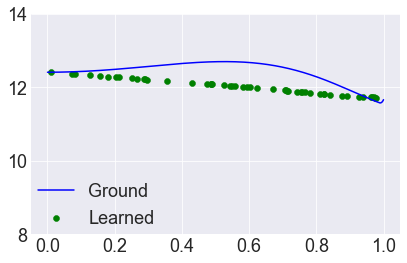

In [76]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
x = sample_x(50)
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()
# ax.set_title('Ground and Learned Potentials')
#ax.set_xlabel('Position')
#ax.set_ylabel('Potential')
plt.plot(xgroundsorted,engroundsorted,color='b',linewidth=1.5)
plt.scatter(x.detach().numpy(), -learned_energy_function(x).detach().numpy(),color='g',linestyle='-',marker='o',linewidth=0.5)
#plt.plot(xsorted,potsorted,color='g',linewidth='1',alpha=0.5)
# Create an inset outside the axes
# plt.suptitle("Ground and Learned Potentials", fontsize=13, fontweight=0, color='black', style='italic')

#plt.legend(['Ground','Learned'],bbox_to_anchor=(0.1, 0.93), loc='lower left', borderaxespad=0.0)
plt.legend(['Ground','Learned'],loc='lower left', borderaxespad=0.0)
# Create an inset with a 2-tuple bounding box. Note that this creates a
# bbox without extent. This hence only makes sense when specifying
# width and height in absolute units (inches).
# axins2 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.05, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)

# axins2.plot(xgroundsorted,potgroundsorted,label='Ground',color='b')
# axins2.set_xlabel('Position')
# axins2.set_ylabel('Potential')
# axins2.set_title('Ground Potential')

# axins3 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.39, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)
# axins3.plot(xgroundsorted,potsorted,label='Learned',color='g')
# axins3.set_xlabel('Position')
# axins3.set_ylabel('Potential')
# axins3.set_title('Learned Potential')

major_ticks_x = np.arange(0, 1.1, .2)
minor_ticks_x = np.arange(0, 1.1, .2)
major_ticks_y = np.arange(8, 16, 2)
minor_ticks_y = np.arange(8, 16, 2)
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
plt.rc('font', size=18)
plt.rc('axes', titlesize=18) 

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
plt.tight_layout()
#plt.savefig('energy_PIB.png',dpi=1200)

In [49]:
x = torch.rand(100,1)
torch.mean((potential(x)-(10*(x**2)))**2)

tensor(0.1891, grad_fn=<MeanBackward0>)

In [50]:
np.sqrt(.1891)

0.434856298103178

In [79]:
torch.mean((-learned_energy_function(x)-12.51435)**2)

tensor(0.3032, grad_fn=<MeanBackward0>)

In [80]:
np.sqrt(.3032)

0.5506359959174482